In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, Input, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras import layers
import numpy as np
from tqdm import tqdm
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
images_dir = '/content/drive/MyDrive/dataset/images'
masks_dir = '/content/drive/MyDrive/dataset/masks'

In [4]:
def double_conv_block(x, n_filters):
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   return x

def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = layers.MaxPool2D(2)(f)
   p = layers.Dropout(0.3)(p)
   return f, p

def upsample_block(x, conv_features, n_filters):
   x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   x = layers.concatenate([x, conv_features])
   x = layers.Dropout(0.3)(x)
   x = double_conv_block(x, n_filters)
   return x

In [5]:
def build_unet_model():
   inputs = layers.Input(shape=(128,128,3))
   f1, p1 = downsample_block(inputs, 64)
   f2, p2 = downsample_block(p1, 128)
   f3, p3 = downsample_block(p2, 256)
   f4, p4 = downsample_block(p3, 512)

   bottleneck = double_conv_block(p4, 1024)

   u6 = upsample_block(bottleneck, f4, 512)
   u7 = upsample_block(u6, f3, 256)
   u8 = upsample_block(u7, f2, 128)
   u9 = upsample_block(u8, f1, 64)

   outputs = layers.Conv2D(1, 1, padding="same", activation = "sigmoid")(u9)

   unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

   return unet_model


In [6]:
def dice_coefficient(y_true, y_pred):
  smooth = 1e-6  # Smoothing factor to avoid division by zero
  intersection = tf.reduce_sum(y_true * y_pred)
  union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
  dice = (2. * intersection + smooth) / (union + smooth)
  return dice

def iou(y_true, y_pred):
  intersection = tf.reduce_sum(y_true * y_pred)
  union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
  smooth = 1e-6
  return (intersection + smooth) / (union - intersection + smooth)

def precision(y_true, y_pred):
  intersection = tf.reduce_sum(y_true * y_pred)
  union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
  smooth = 1e-6
  return (intersection + smooth) / (tf.reduce_sum(y_pred)+ smooth)

def recall(y_true, y_pred):
  intersection = tf.reduce_sum(y_true * y_pred)
  union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
  smooth = 1e-6
  return (intersection + smooth) / (tf.reduce_sum(y_true)+ smooth)


In [7]:
unet_model = build_unet_model()
unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                   loss=tf.keras.losses.BinaryCrossentropy(),
                   metrics=["accuracy", dice_coefficient, iou, precision, recall])

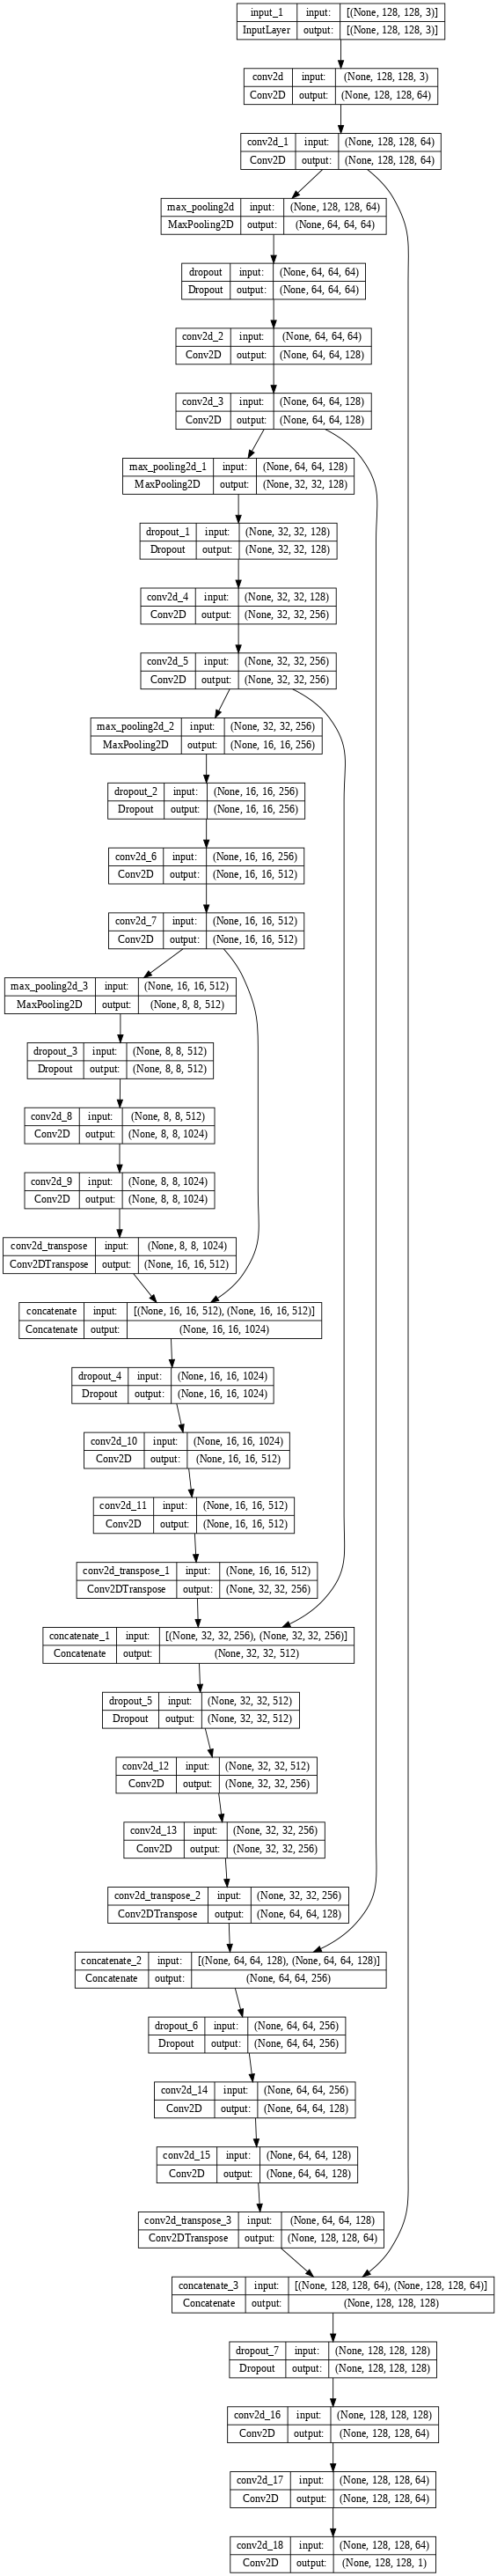

In [8]:
tf.keras.utils.plot_model(unet_model, show_shapes=True, expand_nested=True, dpi=64)

In [9]:
def resize(input_image, input_mask):
   input_image = tf.image.resize(input_image, (128, 128), method="nearest")
   input_mask = tf.image.resize(input_mask, (128, 128), method="nearest")
   return input_image, input_mask

def augment(input_image, input_mask):
   if tf.random.uniform(()) > 0.5:
       # Random flipping of the image and mask
       input_image = tf.image.flip_left_right(input_image)
       input_mask = tf.image.flip_left_right(input_mask)
   return input_image, input_mask

def normalize(input_image, input_mask):
   input_image = tf.cast(input_image, tf.float32) / 255.0
   input_mask -= 255
   return input_image, input_mask

In [10]:
def load_image_and_mask(image_file, mask_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image, channels=3)
    mask = tf.io.read_file(mask_file)
    mask = tf.image.decode_png(mask, channels=1)
    return image, mask

def load_image_train(image_file, mask_file):
    input_image, input_mask = load_image_and_mask(image_file, mask_file)
    input_image, input_mask = resize(input_image, input_mask)
    input_image, input_mask = augment(input_image, input_mask)
    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask

def load_image_test(image_file, mask_file):
    input_image, input_mask = load_image_and_mask(image_file, mask_file)
    input_image, input_mask = resize(input_image, input_mask)
    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask

In [11]:
image_files = sorted([os.path.join(images_dir, filename) for filename in os.listdir(images_dir)])
mask_files = sorted([os.path.join(masks_dir, filename) for filename in os.listdir(masks_dir)])

# 80:20 train:test ratio
split = int(0.2 * len(image_files))

train_dataset = tf.data.Dataset.from_tensor_slices((image_files[split:], mask_files[split:]))
train_dataset = train_dataset.map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((image_files[:split], mask_files[:split]))
test_dataset = test_dataset.map(load_image_test, num_parallel_calls=tf.data.AUTOTUNE)

print("Number of training samples:", len(train_dataset))
print("Number of testing samples:", len(test_dataset))

Number of training samples: 962
Number of testing samples: 240


In [12]:
BATCH_SIZE = 12
BUFFER_SIZE = 150
train_batches = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_batches = train_batches.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_batches = test_dataset.batch(BATCH_SIZE)
test_batches = test_dataset.batch(BATCH_SIZE)

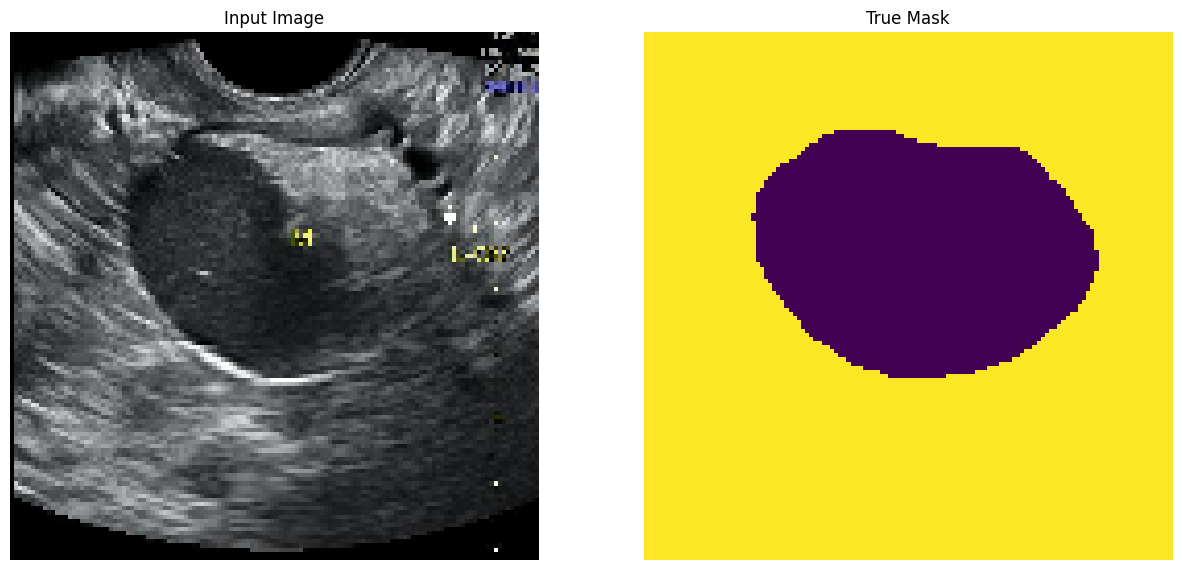

In [13]:
def display(display_list):
 plt.figure(figsize=(15, 15))

 title = ["Input Image", "True Mask", "Predicted Mask"]

 for i in range(len(display_list)):
   plt.subplot(1, len(display_list), i+1)
   plt.title(title[i])
   plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
   plt.axis("off")
 plt.show()

sample_batch = next(iter(train_batches))
random_index = np.random.choice(sample_batch[0].shape[0])
sample_image, sample_mask = sample_batch[0][random_index], sample_batch[1][random_index]
display([sample_image, sample_mask])

In [14]:
NUM_EPOCHS = 20
TRAIN_LENGTH = len(train_dataset)
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
TEST_LENTH = len(test_dataset)
VALIDATION_STEPS = TEST_LENTH // BATCH_SIZE
model_history = unet_model.fit(train_batches,
                              epochs=NUM_EPOCHS,
                              steps_per_epoch=STEPS_PER_EPOCH,
                              validation_steps=VALIDATION_STEPS,
                              validation_data=test_batches)

Epoch 1/20
80/80 [==============================] - 235s 3s/step - loss: 25.1485 - accuracy: 0.8267 - dice_coefficient: 0.7698 - iou: 0.6291 - precision: 0.8375 - recall: 0.7182 - val_loss: 0.4696 - val_accuracy: 0.8247 - val_dice_coefficient: 0.7984 - val_iou: 0.6648 - val_precision: 0.8283 - val_recall: 0.7719
Epoch 2/20
80/80 [==============================] - 28s 255ms/step - loss: 0.4348 - accuracy: 0.8317 - dice_coefficient: 0.8328 - iou: 0.7141 - precision: 0.8425 - recall: 0.8253 - val_loss: 0.4371 - val_accuracy: 0.8247 - val_dice_coefficient: 0.8443 - val_iou: 0.7312 - val_precision: 0.8326 - val_recall: 0.8579
Epoch 3/20
80/80 [==============================] - 20s 256ms/step - loss: 0.4057 - accuracy: 0.8369 - dice_coefficient: 0.8471 - iou: 0.7354 - precision: 0.8483 - recall: 0.8473 - val_loss: 0.4128 - val_accuracy: 0.8247 - val_dice_coefficient: 0.8525 - val_iou: 0.7435 - val_precision: 0.8362 - val_recall: 0.8709
Epoch 4/20
80/80 [==============================] - 20s 

In [15]:
unet_model.save("unet_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 21ms/step


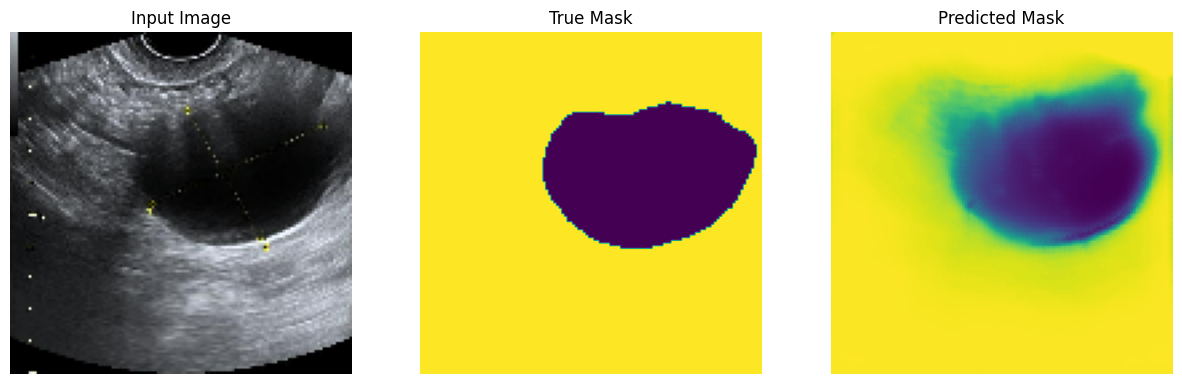

In [18]:
sample_batch = next(iter(test_batches))
random_index = np.random.choice(sample_batch[0].shape[0])
sample_image, sample_mask = sample_batch[0][random_index], sample_batch[1][random_index]
sample_image_batch = np.expand_dims(sample_image, axis=0)
pred = unet_model.predict(sample_image_batch)
image = np.squeeze(pred, axis=0)
display([sample_image, sample_mask, image])

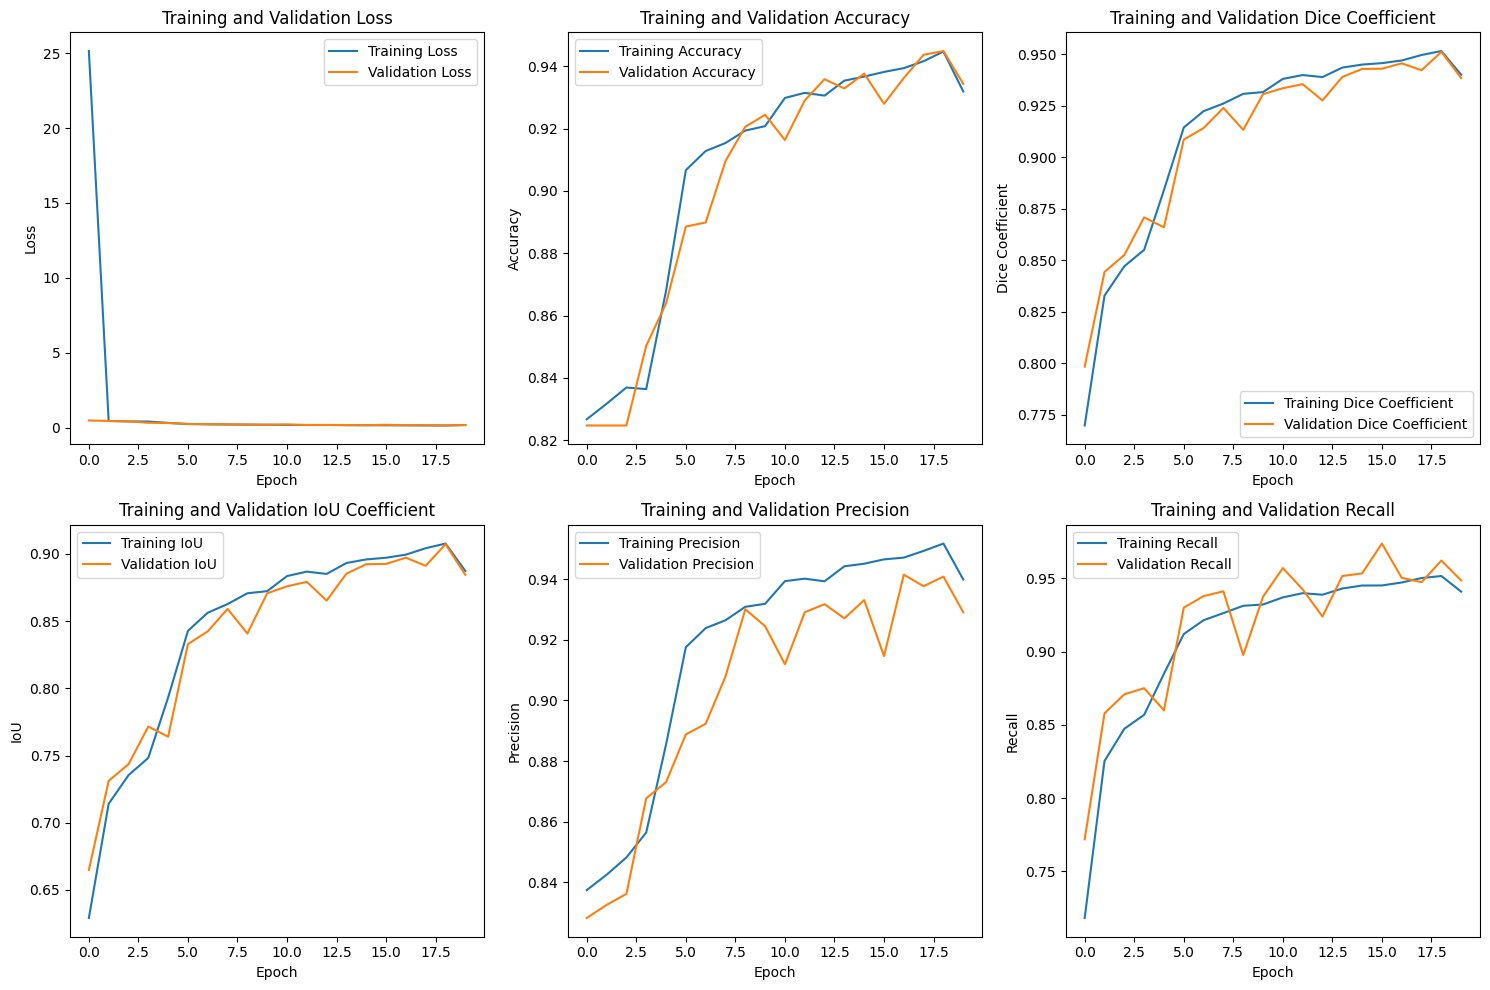

In [17]:
def plot_metrics(history):
    # Extract metrics from history
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    dice_coefficient = history.history['dice_coefficient']
    val_dice_coefficient = history.history['val_dice_coefficient']
    iou = history.history['iou']
    val_iou = history.history['val_iou']
    precision = history.history['precision']
    val_precision = history.history['val_precision']
    recall = history.history['recall']
    val_recall = history.history['val_recall']
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))

    axs[0, 0].plot(loss, label='Training Loss')
    axs[0, 0].plot(val_loss, label='Validation Loss')
    axs[0, 0].set_xlabel('Epoch')
    axs[0, 0].set_ylabel('Loss')
    axs[0, 0].set_title('Training and Validation Loss')
    axs[0, 0].legend()

    axs[0, 1].plot(accuracy, label='Training Accuracy')
    axs[0, 1].plot(val_accuracy, label='Validation Accuracy')
    axs[0, 1].set_xlabel('Epoch')
    axs[0, 1].set_ylabel('Accuracy')
    axs[0, 1].set_title('Training and Validation Accuracy')
    axs[0, 1].legend()

    axs[0, 2].plot(dice_coefficient, label='Training Dice Coefficient')
    axs[0, 2].plot(val_dice_coefficient, label='Validation Dice Coefficient')
    axs[0, 2].set_xlabel('Epoch')
    axs[0, 2].set_ylabel('Dice Coefficient')
    axs[0, 2].set_title('Training and Validation Dice Coefficient')
    axs[0, 2].legend()

    axs[1, 0].plot(iou, label='Training IoU')
    axs[1, 0].plot(val_iou, label='Validation IoU')
    axs[1, 0].set_xlabel('Epoch')
    axs[1, 0].set_ylabel('IoU')
    axs[1, 0].set_title('Training and Validation IoU Coefficient')
    axs[1, 0].legend()

    axs[1, 1].plot(precision, label='Training Precision')
    axs[1, 1].plot(val_precision, label='Validation Precision')
    axs[1, 1].set_xlabel('Epoch')
    axs[1, 1].set_ylabel('Precision')
    axs[1, 1].set_title('Training and Validation Precision')
    axs[1, 1].legend()

    axs[1, 2].plot(recall, label='Training Recall')
    axs[1, 2].plot(val_recall, label='Validation Recall')
    axs[1, 2].set_xlabel('Epoch')
    axs[1, 2].set_ylabel('Recall')
    axs[1, 2].set_title('Training and Validation Recall')
    axs[1, 2].legend()

    plt.tight_layout()

    plt.savefig("metrics.png")
    plt.show()

plot_metrics(model_history)
